# About
Roughwork code for comparing tails.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import fattails.metrics as fattails

Datasource:
* BTC: https://finance.yahoo.com/quote/BTC-USD/history/
* ETH: https://finance.yahoo.com/quote/ETH-USD/history/

In [2]:
btc_filepath = '../data/crypto/BTC-USD.csv'
eth_filepath = '../data/crypto/ETH-USD.csv'

# Setup

In [3]:
def prices_to_returns(prices):
    """ Convert price data into percentage return data.

    Each data entry is replaced by it's percentage change 
    vs. the entry before it.
    
    Parameters
    ----------
    sr : pd.Series
        Price data.

    Returns
    -------
    returns : pd.Series
        Percentage return data.
        
    Example
    -------
    >>> # Initialise a price series
    >>> prices = pd.Series([100, 101, 100, 125])
    0    100
    1    101
    2    100
    3    125
    dtype: int64
    >>> # Convert Prices to Returns
    >>> convert_prices_to_returns(prices)
    1    0.010000
    2   -0.009901
    3    0.250000
    dtype: float64
    """
    # Caluculate Returns
    previous_prices = prices.shift(1)
    returns = prices / previous_prices - 1
    
    # Remove First Period
    returns = returns.iloc[1:]  # The first entry has no prior day so return is NaN
        
    return returns

In [4]:
prices = pd.Series([100, 101, 100, 125])

prices_to_returns(prices)

1    0.010000
2   -0.009901
3    0.250000
dtype: float64

##### Load Data

In [5]:
# Load Prices
btc_prices = pd.read_csv(btc_filepath, index_col=0, parse_dates=[0])
btc_prices = btc_prices.Close.rename('prices')
display(btc_prices)

eth_prices = pd.read_csv(eth_filepath, index_col=0, parse_dates=[0])
eth_prices = eth_prices.Close.rename('prices')

display(eth_prices)

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2021-04-19    55724.265625
2021-04-20    56473.031250
2021-04-21    53906.089844
2021-04-22    51762.273438
2021-04-23    49192.179688
Name: prices, Length: 2411, dtype: float64

Date
2015-08-07       2.772120
2015-08-08       0.753325
2015-08-09       0.701897
2015-08-10       0.708448
2015-08-11       1.067860
                 ...     
2021-04-19    2166.188721
2021-04-20    2330.210938
2021-04-21    2364.751709
2021-04-22    2403.535156
2021-04-23    2235.869873
Name: prices, Length: 2087, dtype: float64

In [6]:
# Calculate Returns
btc_returns = prices_to_returns(btc_prices)
eth_returns = prices_to_returns(eth_prices)

basket_returns = (btc_returns + eth_returns)/2  # Basket where you rebalance to 50:50 at end of each day.
basket_returns

Date
2014-09-18         NaN
2014-09-19         NaN
2014-09-20         NaN
2014-09-21         NaN
2014-09-22         NaN
                ...   
2021-04-19   -0.020232
2021-04-20    0.044578
2021-04-21   -0.015316
2021-04-22   -0.011684
2021-04-23   -0.059705
Name: prices, Length: 2410, dtype: float64

In [7]:
# Create DataFrame
returns_df = pd.concat([btc_returns, eth_returns], \
                       keys=['btc_returns','eth_returns'], \
                       axis=1, join='inner')

# Add Mean Return Column
returns_df['mean_returns'] = returns_df.mean(axis=1)

returns_df.head()

,btc_returns,eth_returns,mean_returns
Date,,,
2015-08-08,-0.066484,-0.728249,-0.397367
2015-08-09,0.015655,-0.068268,-0.026306
2015-08-10,-0.002313,0.009333,0.003510
2015-08-11,0.022369,0.507323,0.264846
2015-08-12,-0.014831,0.140075,0.062622


### Missing Data Check

In [8]:
# NaN Values in Returns Data
returns_df.loc[returns_df.isna().any(axis=1)]

,btc_returns,eth_returns,mean_returns
Date,,,
2020-04-17,NaN,NaN,NaN
2020-04-18,NaN,NaN,NaN
2020-10-09,NaN,NaN,NaN
2020-10-10,NaN,NaN,NaN
2020-10-12,NaN,NaN,NaN
2020-10-13,NaN,NaN,NaN
2020-10-14,NaN,NaN,NaN


In [9]:
# NaN Values in ETH Prices
eth_prices.iloc[1:][returns_df.isna().any(axis=1)]

Date
2020-04-17           NaN
2020-04-18    186.914001
2020-10-09           NaN
2020-10-10    370.967590
2020-10-12           NaN
2020-10-13           NaN
2020-10-14    379.484039
Name: prices, dtype: float64

In [10]:
# NaN Values in BTC Prices
btc_prices.loc[returns_df.index][returns_df.isna().any(axis=1)]

Date
2020-04-17             NaN
2020-04-18     7257.665039
2020-10-09             NaN
2020-10-10    11296.361328
2020-10-12             NaN
2020-10-13             NaN
2020-10-14    11429.506836
Name: prices, dtype: float64

In [11]:
# Drop Nan Values from Returns
returns_df.dropna(inplace=True)

# Analyse

### Simple Plot

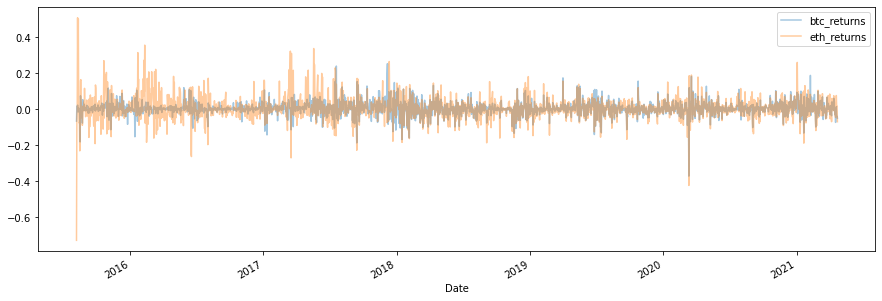

In [12]:
# Plot
returns_df.loc[:,['btc_returns','eth_returns']].plot(figsize=[15,5], alpha=0.4);

### Deviation

Notice above how ETH was noticeably wilder than BTC in the early years. I'm guessing that's because ETH was newer at the time.

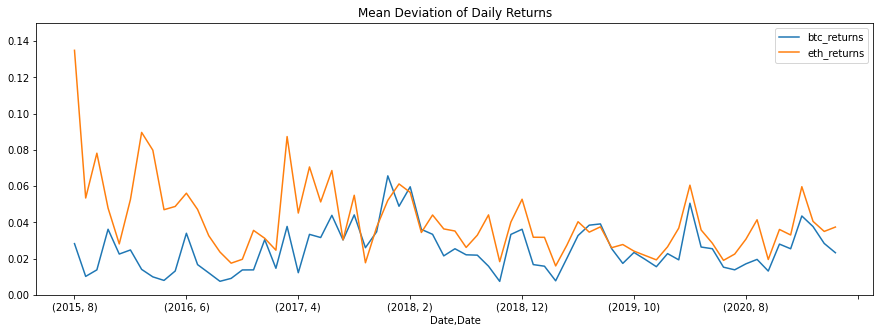

In [13]:
# Plot Monthly Mean Deviation
monthly_mad = returns_df.groupby([returns_df.index.year, returns_df.index.month]) \
                       .mad()

monthly_mad.loc[:,['btc_returns','eth_returns']] \
           .plot(figsize=[15,5], title='Mean Deviation of Daily Returns', ylim=[0,0.15]);

##### Deviation Ratio
Look at the ratio of mean deviation to standard deviation.

In [14]:
# Calculate Monthly Standard Deviation
monthly_std = returns_df.groupby([returns_df.index.year, returns_df.index.month]) \
                       .std()
monthly_std.head()

btc_returns  eth_returns  mean_returns
Date Date                                        
2015 8        0.048987     0.230374      0.126351
     9        0.012991     0.072986      0.035213
     10       0.019104     0.102568      0.055320
     11       0.049759     0.065109      0.046395
     12       0.033057     0.036069      0.028804

In [15]:
monthly_deviation_ratio = monthly_std/monthly_mad

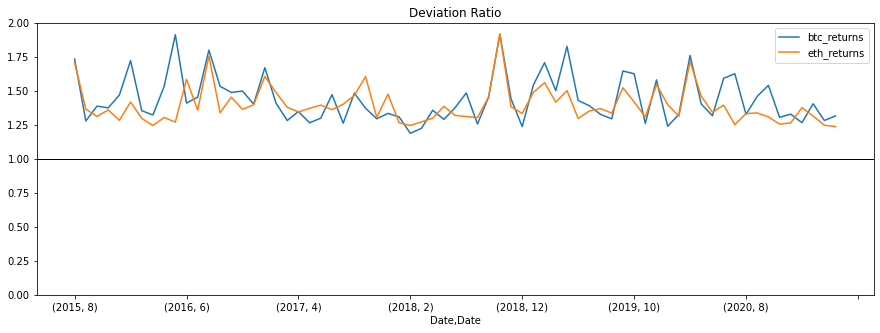

In [16]:
# Plot the Deviation Ratio
ax = monthly_deviation_ratio.loc[:,['btc_returns','eth_returns']] \
                       .plot(figsize=[15,5], title='Deviation Ratio', \
                             ylim=(0,2));
ax.axhline(1, color='k', linewidth=1);

The plot above tells us that the deviation ratio is between 1.25 and 2. For context a normal distribution has a ratio of 1.25. So as expected, we've got something fatter than the gaussian.

Somewhat surprisingly, the BTC ratio is higher. So even though mean deviation looks lower for BTC, the deviation ratio is indicating that BTC is fatter tailed. 

### Body of Distribution

------------------------
Year = 2015


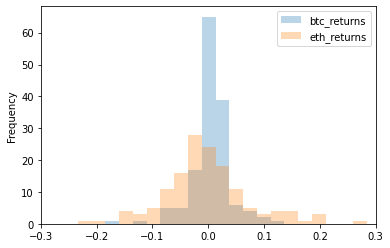

------------------------
Year = 2016


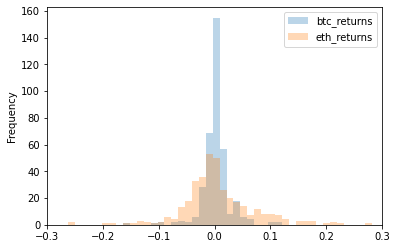

------------------------
Year = 2017


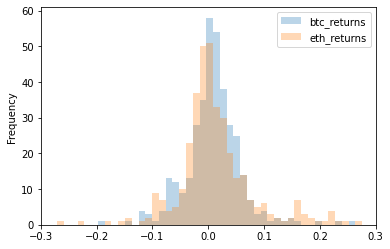

------------------------
Year = 2018


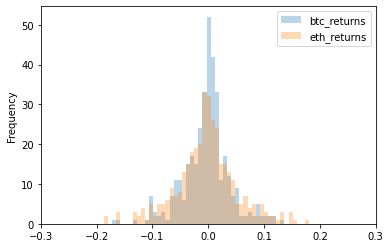

------------------------
Year = 2019


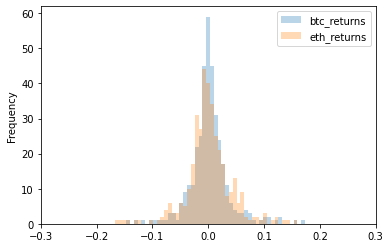

------------------------
Year = 2020


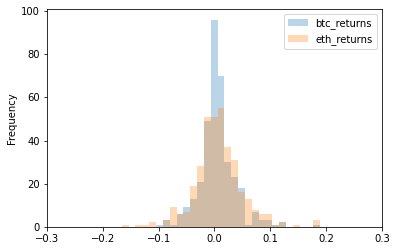

------------------------
Year = 2021


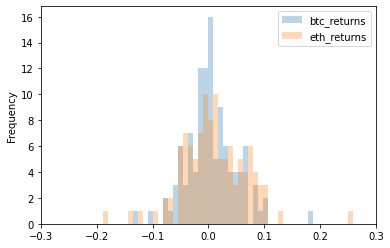

In [17]:
# Histogram for each year
years = returns_df.index.year.unique()

for year in years:
    print('------------------------')
    print(f'Year = {year}')
    returns_df.loc[returns_df.index.year == year] \
              .loc[:,['btc_returns','eth_returns']] \
              .plot(kind='hist', bins=50, alpha=0.3, xlim=[-0.3, 0.3]);
    plt.show()

Above we see a higher peak for BTC. This suggests that BTC is fatter tailed than ETH.

# Tail Analysis

##### Right Tail

In [18]:
def survival_probability_df(df, reset_index=True):
    """ Return in-sample survival probabilities for each value.
    
    Returns
    -------
    survival_df : pd.DataFrame
        Each column in the input is sorted (descending). 
        Then the index is replaced with survival probabilities.
        If reset_index=True the index is reset to make plotting easier.
    """
    # Determine the Granularity
    # Probability increment between each row 
    probability_increments = 1 / (len(df)+1)
    probability_increments

    # Create Index with Survival Probabilities
    survival_index = np.arange(probability_increments, 1, probability_increments)
    survival_index = pd.Index(survival_index, name='survival_probability')
    survival_index

    # Sort the input Columns
    # The pattern [::-1] is used to a get descending sort
    sorted_df = pd.DataFrame(np.sort(df.values, axis=0)[::-1], index=df.index, columns=df.columns)

    # Apply Probability Index
    survival_df = sorted_df.copy()
    survival_df.index = survival_index
    
    if reset_index:
        survival_df.reset_index(inplace=True)  # Reset the index to make plotting easier
    
    return survival_df

In [19]:
# Create Survival df
survival_df = survival_probability_df(returns_df)
survival_df

,survival_probability,btc_returns,eth_returns,mean_returns
0,0.000481,0.252472,0.507323,0.264846
1,0.000962,0.239361,0.501240,0.246310
2,0.001442,0.199283,0.355444,0.194536
3,0.001923,0.187465,0.336621,0.191941
4,0.002404,0.181878,0.322054,0.188688
...,...,...,...,...
2074,0.997596,-0.159688,-0.253140,-0.176474
2075,0.998077,-0.168548,-0.263130,-0.192707
2076,0.998558,-0.181788,-0.270518,-0.207746
2077,0.999038,-0.187411,-0.423472,-0.397367


In [20]:
# Check Sorted min and max values
survival_df.agg(['max','min'])

,survival_probability,btc_returns,eth_returns,mean_returns
max,0.999519,0.252472,0.507323,0.264846
min,0.000481,-0.371695,-0.728249,-0.397584


# Tail Plot

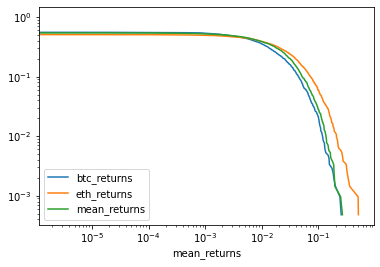

In [21]:
ax = None
for col in survival_df.columns[1:]:
    
    if ax == None:
        ax = survival_df.plot(col, 'survival_probability', label=col, loglog=True)
    else:
        survival_df.plot(col, 'survival_probability', label=col, ax=ax);        